WeGo Public Transit

WeGo Public Transit is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

In this project, you'll be analyzing the bus spacing to look for patterns and try to identify correlations to controllable or external factors. Specifically, you'll be using a dataset containing information on the headway, or amount of time between vehicle arrivals at a stop. This dataset contains a column HDWY_DEV, which shows the headway deviation. This variable will be negative when bunching has occurred (shorter headway than scheduled) and will be positive for gapping (longer headway than scheduled). Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY.

#### Goals of this project:

How much impact does being late or too spaced out at the first stop have downstream?

What is the impact of the layover at the start of the trip (the difference between the first top arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?

How closely does lateness (ADHERENCE) correlate to headway?

What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has travelled?

How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

How does direction of travel, route, or location affect the headway and on-time performance?

#### How does time of day or day of week affect headway and on-time performance? Can you detect an impact of school schedule on headway deviation (for certain routes and at certain times of day)?

#### Does weather have any effect on headway or on-time performance? To help answer this question, the file bna_weather.csv contains historical weather data recorded at Nashville International Airport.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
transit_df = pd.read_csv(r"C:\Users\ndidi\Documents\NSS_Projects\wego-creepin-it-real-wego\Data\headway_data_with_routes.csv", index_col=0)
pd.set_option('display.max_columns', None)

transit_df.head()

,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,ARRIVAL_STATUS
0,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,04:42:00,04:37:38,04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,ON TIME
1,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,04:46:00,04:48:27,04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,ON TIME
2,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,04:54:00,04:54:56,04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,ON TIME
3,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,05:10:00,05:03:43,05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,ON TIME
4,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,05:15:00,05:03:43,05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,ON TIME


#### How does time of day affect headway and on-time performance?

headway: amount of time between vehicle arrivals at a stop

In [3]:
# concatenate date & time variables

transit_df['Scheduled_Time_with_Date'] = transit_df['DATE'] + ' ' + transit_df['SCHEDULED_TIME']
transit_df['Actual_Arrival_with_Date'] = transit_df['DATE'] + ' ' + transit_df['ACTUAL_ARRIVAL_TIME']
transit_df['Actual_Departure_with_Date'] = transit_df['DATE'] + ' ' + transit_df['ACTUAL_DEPARTURE_TIME']

transit_df.head()

,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,ARRIVAL_STATUS,Scheduled_Time_with_Date,Actual_Arrival_with_Date,Actual_Departure_with_Date
0,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,04:42:00,04:37:38,04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,ON TIME,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08
1,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,04:46:00,04:48:27,04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,ON TIME,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27
2,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,04:54:00,04:54:56,04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,ON TIME,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56
3,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,05:10:00,05:03:43,05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,ON TIME,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43
4,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,05:15:00,05:03:43,05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,ON TIME,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35


In [4]:
# convert date & time variables to datetime
transit_df['Scheduled_Time_with_Date'] = pd.to_datetime(transit_df['Scheduled_Time_with_Date'], utc=True)
transit_df['Actual_Arrival_with_Date'] = pd.to_datetime(transit_df['Actual_Arrival_with_Date'], utc=True)
transit_df['Actual_Departure_with_Date'] = pd.to_datetime(transit_df['Actual_Departure_with_Date'], utc=True)

In [5]:
transit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350328 entries, 0 to 350327
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   SERVICE_ABBR                350328 non-null  int64              
 1   ADHERENCE_ID                350328 non-null  int64              
 2   DATE                        350328 non-null  object             
 3   ROUTE_ABBR                  350328 non-null  object             
 4   BLOCK_ABBR                  350328 non-null  int64              
 5   OPERATOR                    350328 non-null  int64              
 6   TRIP_ID                     350328 non-null  int64              
 7   OVERLOAD_ID                 350328 non-null  int64              
 8   ROUTE_DIRECTION_NAME        350328 non-null  object             
 9   TIME_POINT_ABBR             350328 non-null  object             
 10  ROUTE_STOP_SEQUENCE         350317 non-null 

In [6]:
transit_df['Actual_Arrival_Hour'] = transit_df['Actual_Arrival_with_Date'].dt.hour
transit_df.head()

,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,ARRIVAL_STATUS,Scheduled_Time_with_Date,Actual_Arrival_with_Date,Actual_Departure_with_Date,Actual_Arrival_Hour
0,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,04:42:00,04:37:38,04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,2,6.500000,ON TIME,2023-08-01 04:42:00+00:00,2023-08-01 04:37:38+00:00,2023-08-01 04:44:08+00:00,4.0
1,1,99457891,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,04:46:00,04:48:27,04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,9,0.000000,ON TIME,2023-08-01 04:46:00+00:00,2023-08-01 04:48:27+00:00,2023-08-01 04:48:27+00:00,4.0
2,1,99457892,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,04:54:00,04:54:56,04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,19,0.000000,ON TIME,2023-08-01 04:54:00+00:00,2023-08-01 04:54:56+00:00,2023-08-01 04:54:56+00:00,4.0
3,1,99457893,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,05:10:00,05:03:43,05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,35,0.000000,ON TIME,2023-08-01 05:10:00+00:00,2023-08-01 05:03:43+00:00,2023-08-01 05:03:43+00:00,5.0
4,1,99457894,2023-08-01,BORDEAUX,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,05:15:00,05:03:43,05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,36,12.866666,ON TIME,2023-08-01 05:15:00+00:00,2023-08-01 05:03:43+00:00,2023-08-01 05:16:35+00:00,5.0


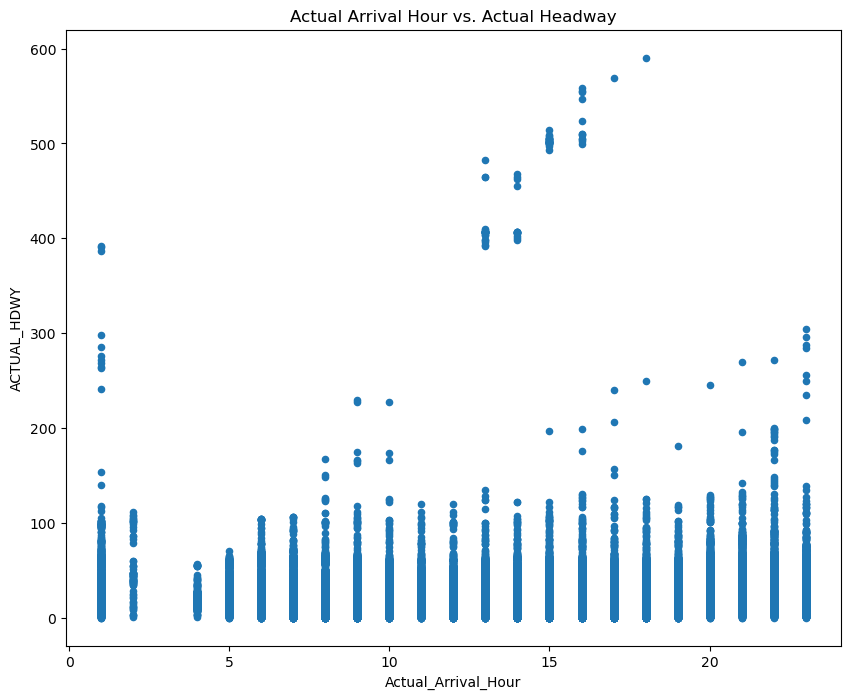

In [7]:
# scatter plot hour vs actual_hdwy
transit_df.plot(kind = 'scatter', x = 'Actual_Arrival_Hour', y = 'ACTUAL_HDWY', figsize = (10,8))
plt.title('Actual Arrival Hour vs. Actual Headway'); # -> 13 - 16 [1pm-4pm] seem to have larger headway values; 
# -> 17 - 18 [5pm-6pm] outliers?

In [8]:
# bar plot hour vs actual_hdwy
transit_df.plot(kind = 'bar', x = 'Actual_Arrival_Hour', y = 'ACTUAL_HDWY', figsize = (12,8))
plt.title('Actual Arrival Hour vs. Actual Headway'); # -> kernels taking long to load?

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002886D5C49A0> (for post_execute):


KeyboardInterrupt: 

In [10]:
transit_df['ACTUAL_HDWY'].min()

0.0

In [11]:
transit_df['ACTUAL_HDWY'].max()

590.433333

In [12]:
transit_df['HDWY_DEV'].min()

-64.0

In [13]:
transit_df['HDWY_DEV'].max()

565.433333

#### How does day of week affect headway? 
headway: amount of time between vehicle arrivals at a stop

In [14]:
# confirming values
transit_df['SERVICE_ABBR'].unique() # 1 -> weekday; 2 -> saturday; 3 -> sunday

array([1, 2, 3], dtype=int64)

In [15]:
transit_df['SERVICE_ABBR'].shape # amount of entries in variable match total entries in dataframe

(350328,)

In [16]:
transit_df['SERVICE_ABBR'].value_counts()

1    279299
2     37497
3     33532
Name: SERVICE_ABBR, dtype: int64

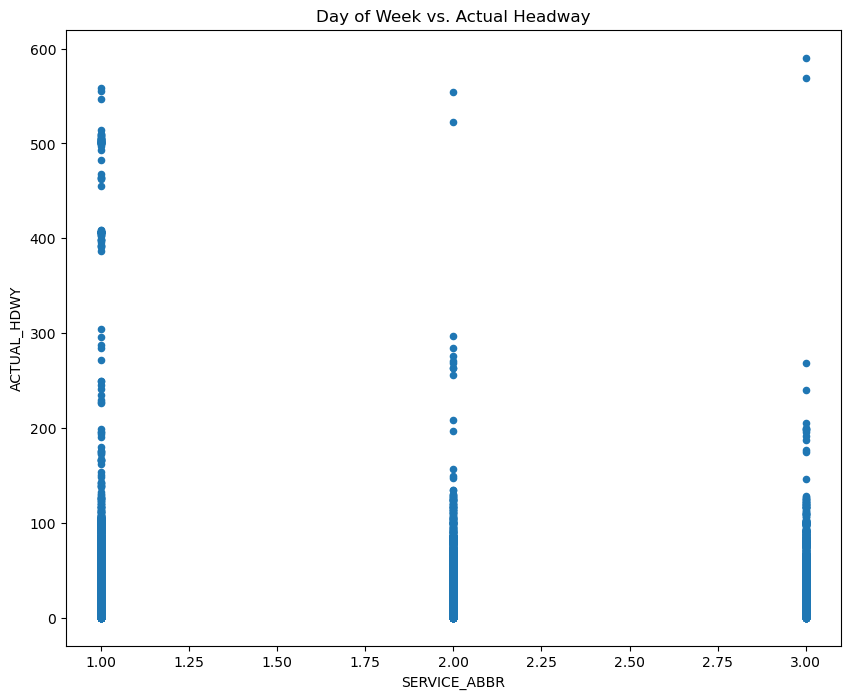

In [17]:
# scatter plot day of week vs actual_hdwy
transit_df.plot(kind = 'scatter', x = 'SERVICE_ABBR', y = 'ACTUAL_HDWY', figsize = (10,8))
plt.title('Day of Week vs. Actual Headway');

In [18]:
# reminder to myself: ask for which holidays are included in this dataset; it was mentioned but I forgot

In [ ]:
# subset early arrivals

early_df = transit_df[transit_df.ARRIVAL_STATUS == 'EARLY']
early_df.head()

In [ ]:
# new df with headway/time/date
headway_early_df = early_df[['Scheduled_Time_with_Date','Actual_Arrival_with_Date', 'Actual_Departure_with_Date', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ARRIVAL_STATUS']]
headway_early_df.head()

In [ ]:
headway_early_df.describe()

In [ ]:
# subset on time arrivals
on_time_df = transit_df[transit_df.ARRIVAL_STATUS == 'ON TIME']
on_time_df.head()

In [ ]:
# new df with headway/time/date
headway_on_time_df = on_time_df[['Scheduled_Time_with_Date','Actual_Arrival_with_Date', 'Actual_Departure_with_Date', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ARRIVAL_STATUS']]
headway_on_time_df

In [ ]:
headway_on_time_df.describe()

In [ ]:
# subset late arrivals
late_df = transit_df[transit_df.ARRIVAL_STATUS == 'LATE']
late_df.head()

In [ ]:
# new df with headway/time/date
headway_late_df = late_df[['Scheduled_Time_with_Date','Actual_Arrival_with_Date', 'Actual_Departure_with_Date', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ARRIVAL_STATUS']]
headway_late_df.head()